## Using Torch TextRNN to Make Inference On Next Word in Document

The below code sample is taken and adapted from [Tae Hwan Jung's code repository](https://github.com/graykode/nlp-tutorial/blob/master/3-1.TextRNN/TextRNN.py). This RNN sequential model is trained to predict the last token of each document.

#### Function to Make Batches of Data

In [46]:
from typing import List, Dict

def make_batch(sentences: List[str], word_dict: Dict):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()  # space tokenizer
        input_text = [word_dict[n] for n in word[:-1]]  # create (1~n-1) as input
        target = word_dict[word[-1]]  # create (n) as target, We usually call this 'casual language model'
        input_batch.append(np.eye(n_class)[input_text])
        target_batch.append(target)

    return input_batch, target_batch

In [17]:
# %%
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        """
        By default, the non-linear function used is tanh.
        """
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Linear(n_hidden, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, hidden, X):
        """
        This is the forward propagation step of the neural network.
        """
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        outputs, hidden = self.rnn(X, hidden)
        # outputs : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        outputs = outputs[-1] # [batch_size, num_directions(=1) * n_hidden]
        model = self.W(outputs) + self.b # model : [batch_size, n_class]
        return model

### Define Model Hyper Parameters

In [18]:
n_step = 2 # number of cells(= number of Step)
n_hidden = 5 # number of hidden units in one cell
n_epochs = 5000 # number of epochs to train for

### Create Some Synthetic Data

In [47]:
sentences = ["i like dog", 
             "i love coffee", 
             "i hate milk",
            "i love cat",
            "i love dog",
            "i love summer"]

### Text Preprocessing and Feature Engineering

Here, we'll use `word_dict` to keep a mapping from the word to its index position in our vocabulary.

In [56]:
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict) #9
batch_size = len(sentences) #6

### Declare Torch RNN Model

We will use cross entropy loss to optimize our model and update weights.

In [49]:
model = TextRNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_batch, target_batch = make_batch(sentences, word_dict)
input_batch = torch.FloatTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

### Perform Training
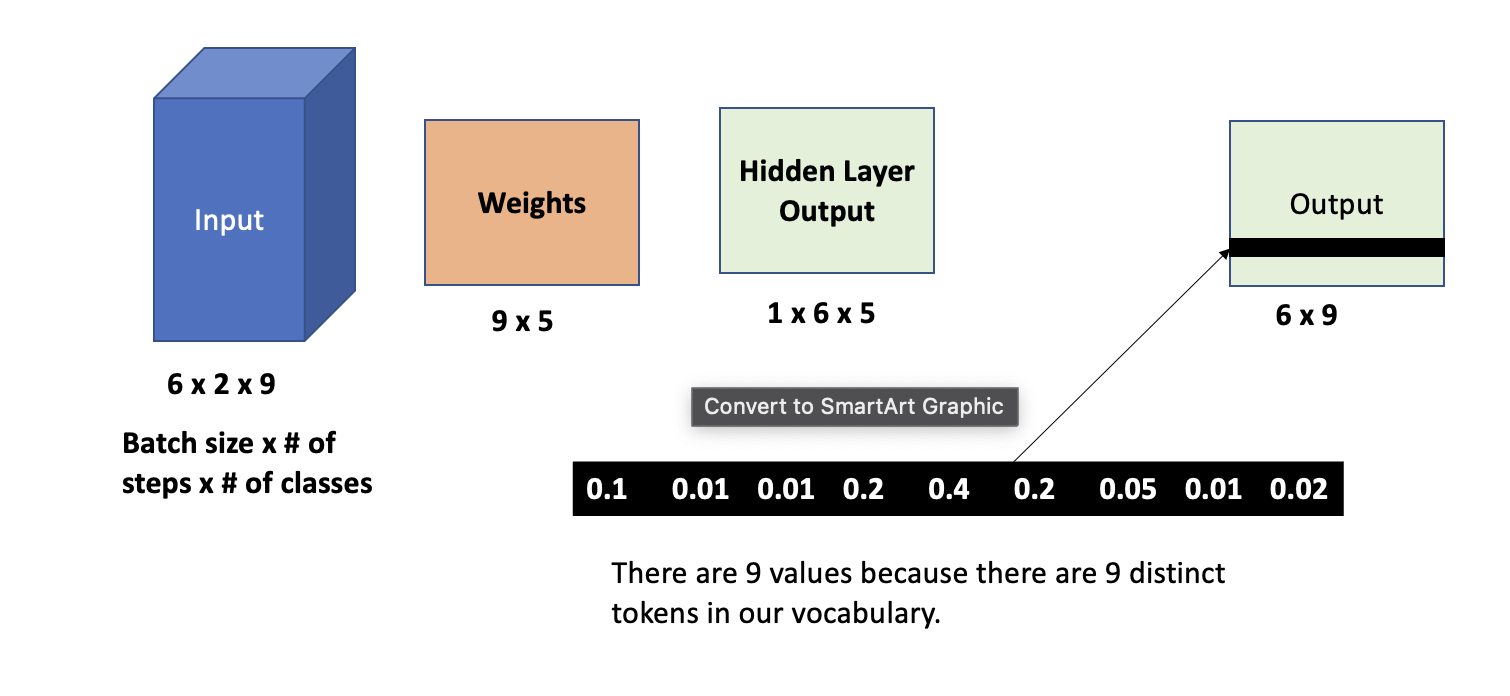

In [50]:
# Training
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # hidden : [num_layers * num_directions, batch, hidden_size]
    hidden = torch.zeros(1, batch_size, n_hidden)
    # input_batch : [batch_size, n_step, n_class]
    output = model(hidden, input_batch)

    # output : [batch_size, n_class], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 1.080427
Epoch: 2000 cost = 0.947754
Epoch: 3000 cost = 0.932738
Epoch: 4000 cost = 0.928236
Epoch: 5000 cost = 0.926339


### Make Inferences

In [52]:
inputs = [sen.split()[:2] for sen in sentences]
inputs

[['i', 'like'],
 ['i', 'love'],
 ['i', 'hate'],
 ['i', 'love'],
 ['i', 'love'],
 ['i', 'love']]

In [53]:
# Predict
hidden = torch.zeros(1, batch_size, n_hidden)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
for sentence, predicted_index in zip(sentences,predict.squeeze()):
    input_text = sentence.split()[:2]
    predicted_next_token = number_dict[predicted_index.item()]
    print(f"{input_text} -> {predicted_next_token}")

['i', 'like'] -> dog
['i', 'love'] -> dog
['i', 'hate'] -> milk
['i', 'love'] -> dog
['i', 'love'] -> dog
['i', 'love'] -> dog


The `predict` object here is a tensor of the index positions for the predicted next token. We can use the `number_dict` to look up what the original token was:

In [54]:
predict

tensor([[2],
        [2],
        [8],
        [2],
        [2],
        [2]])

In [55]:
number_dict

{0: 'coffee',
 1: 'cat',
 2: 'dog',
 3: 'summer',
 4: 'love',
 5: 'like',
 6: 'hate',
 7: 'i',
 8: 'milk'}

### Inspecting the Model's Weight Shape

In [66]:
print(model)

TextRNN(
  (rnn): RNN(9, 5)
  (W): Linear(in_features=5, out_features=9, bias=False)
)
